/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


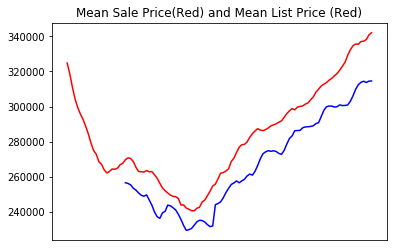

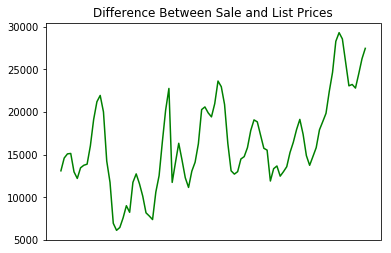

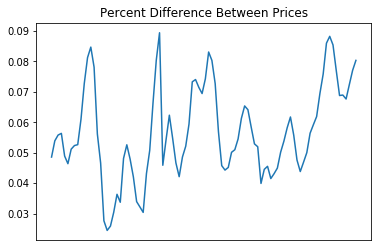

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

listPriceFile = pd.read_csv('../input/listing-price-city/City_MedianListingPrice_AllHomes.csv')
salePriceFile = pd.read_csv('../input/salecity/SaleCity.csv')

listPriceFile = listPriceFile.drop(['RegionName','State','Metro','CountyName','SizeRank','2017-11'], axis=1)
salePriceFile = salePriceFile.drop(['RegionID','RegionName','StateName','SizeRank','2017-11'], axis=1)

#print((salePriceFile.mean()-listPriceFile.mean())/salePriceFile.mean())
ax = plt.axes()
ax.xaxis.set_major_locator(plt.NullLocator())
plt.figure(1)
plt.plot(salePriceFile.mean(), color='red')
plt.plot(listPriceFile.mean(), color='blue')
plt.title("Mean Sale Price(Red) and Mean List Price (Red)")

plt.figure(2) 
plt.plot(salePriceFile.mean()-listPriceFile.mean(), color='green')
ax = plt.axes()
ax.xaxis.set_major_locator(plt.NullLocator())
plt.title("Difference Between Sale and List Prices")

plt.figure(3)
avg = ((salePriceFile.mean()-listPriceFile.mean())/salePriceFile.mean())
plt.plot(avg)
ax = plt.axes()
ax.xaxis.set_major_locator(plt.NullLocator())
plt.title("Percent Difference Between Prices")

plt.show()


The above three plots are a quick look at the data.  Immediately, the hypothesis that list prices would be higher than sale prices is dead.  Universally, sale prices are higher.  This may be due to the inclusion of closing costs in sale price data or it could indicate intense competition in most real estate.

The difference between the means of the two data points could be more telling as we delve further into the data.  The general upward trend of differences (with sale price being higher) could mean a consistently increasing market.

In [ ]:
import plotly.offline as py
import pandas as pd

#Allow for offline use of pyplot - necessary for iPython notebook use
py.init_notebook_mode(connected=True)

#Read in list and sale prices files as well as city for eventual lat/long merge
listPriceFile = pd.read_csv('../input/listing-price-city/City_MedianListingPrice_AllHomes.csv')
salePriceFile = pd.read_csv('../input/salecity/SaleCity.csv')
cities = pd.read_csv('../input/cities3/cities2.csv')

#Working first with listprice file and cities, drop irrelevant columns
cities = cities.drop(['city_ascii','pop','country','iso2','iso3',], axis=1)
listPriceFile = listPriceFile.drop(['Metro','CountyName','SizeRank'], axis=1)

#listPriceFile has the city name in the "RegionName" attribute and an abbreviated state in "State"
#cities uses "city" and "abbr" for the same.  Merging across these parameters ensures
#only the same cities are linked, i.e. Springfield, IL is merged with Springfield, IL and not
#Springfield, MA.
newdf=listPriceFile.merge(cities, left_on=['RegionName','State'], right_on=['city','abbr'], how='outer')

#Get rid of "city" since it is redundant with "RegionName"
newdf=newdf.drop(['city'], axis=1)

#If we merged and included a city that we don't have real estate data for, get rid of it.  Also,
#get rid of cities that we have real estate data but no lat/long.
newdf=newdf.dropna(subset=['RegionName','lat'])


#Build a new column for showing hover-over text in the graphic
newdf['text'] = newdf['RegionName'] + ', ' + newdf['State'] + ' ' + newdf['2017-11'].astype(str)

#We define the color scale of a 15-part gradient from pure red (low) to pure blue (high) 
#taken from http://www.perbang.dk/rgbgradient/
scl = [ [0,"rgb(FF0000)"],[1./16384,"rgb(EC0012)"],[1./8192,"rgb(DA0024)"],
      [1./4096,"rgb(C80036)"],[1./2048,"rgb(B60048)"],[1./1024,"rgb(A3005B)"],[1./512,"rgb(91006D)"],
      [1./256,"rgb(7F007F)"],[1./128,"rgb(6D0091)"],[1./64,"rgb(5B0083)"],[1./32,"rgb(4800B6)"],
      [1./16,"rgb(3600C8)"],[1./8,"rgb(2400DA)"],[0.25,"rgb(12OOEC)"],[1,"rgb(000FF)"]]

#Define the data that will eventually be plotted, how, and on what.  "Scattergeo" is fairly self-
#explanatory.  Note, we define the absolute highest price (SanFrancisco) as pure blue and
#seek to distribute the rest amongst the scale.
data = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = newdf['lng'],
        lat = newdf['lat'],
        text = newdf['text'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = scl,
            cmin = newdf['2012-01'].min(),
            color = newdf['2017-11'],
            cmax = newdf['2017-11'].max(),
            colorbar=dict(
                title="ListPrice"
            )
        ))]

layout = dict(
        title = 'List Prices',
        colorbar = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='Country-Wide List prices' )

I'm going to leave the above result in as an example of information and data that, while true, is not very useful.  As you can see, evenly spacing the steps between the different "chunks" of the list price scale leaves the vast majority of the country between $100,000 and $250,000 which is essentially split between two colors of the 15.  We need to be able to show a more distinction or we are left with what we have, a mostly red country with a few spots with a bit of blue.

In [2]:
import plotly.offline as py
import pandas as pd

#Allow for offline use of pyplot - necessary for iPython notebook use
py.init_notebook_mode(connected=True)

#Read in list and sale prices files as well as city for eventual lat/long merge
listPriceFile = pd.read_csv('../input/listing-price-city/City_MedianListingPrice_AllHomes.csv')
salePriceFile = pd.read_csv('../input/salecity/SaleCity.csv')
cities = pd.read_csv('../input/cities3/cities2.csv')

#Working first with listprice file and cities, drop irrelevant columns
cities = cities.drop(['city_ascii','pop','country','iso2','iso3',], axis=1)
listPriceFile = listPriceFile.drop(['Metro','CountyName','SizeRank'], axis=1)

#listPriceFile has the city name in the "RegionName" attribute and an abbreviated state in "State"
#cities uses "city" and "abbr" for the same.  Merging across these parameters ensures
#only the same cities are linked, i.e. Springfield, IL is merged with Springfield, IL and not
#Springfield, MA.
newdf=listPriceFile.merge(cities, left_on=['RegionName','State'], right_on=['city','abbr'], how='outer')
saledf = salePriceFile.merge(cities, left_on=['RegionName','State'], right_on=['city','abbr'], how='outer')

#Get rid of "city" since it is redundant with "RegionName"
newdf=newdf.drop(['city'], axis=1)
saledf=saledf.drop(['city'], axis=1)

#If we merged and included a city that we don't have real estate data for, get rid of it.  Also,
#get rid of cities that we have real estate data but no lat/long.
newdf=newdf.dropna(subset=['RegionName','lat'])
saledf=saledf.dropna(subset=['RegionName','lng'])

#Build a new column for showing hover-over text in the graphic
newdf['text'] = newdf['RegionName'] + ', ' + newdf['State'] + ' ' + newdf['2017-11'].astype(str)
saledf['text'] = saledf['RegionName'] + ', ' + saledf['StateName'] + ' ' + saledf['2017-11'].astype(str)


#Define the data that will eventually be plotted, how, and on what.  "Scattergeo" is fairly self-
#explanatory.  Note, we define the absolute highest price (SanFrancisco) as pure blue and
#seek to distribute the rest amongst the scale.
data = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = newdf['lng'],
        lat = newdf['lat'],
        text = newdf['text'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = False,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'Portland',
            cmin = 50000,
            color = newdf['2017-11'],
            cmax = 600000,
            colorbar=dict(
                title="ListPrice",
            )
        ))]

layout = dict(
        title = 'List Prices Mean',
        colorbar = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

saledata = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = saledf['lng'],
        lat = saledf['lat'],
        text = saledf['text'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = False,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'Portland',
            cmin = 50000,
            color = saledf['2017-11'],
            cmax = 600000,
            colorbar=dict(
                title="SalePrice",
            )
        ))]

salelayout = dict(
        title = 'Sale Prices 2017-11',
        colorbar = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

#Start making the subtracted dataframe
renamer = {}
year = 2006
month = 0
for i in range(0,200):
    if (month %12+1 < 10):
        monthstr = '0' + str(month%12+1)
    else:
        monthstr = str(month%12+1)
    stringrep = str(year) +'-'+ monthstr
    renamer[stringrep] = stringrep+'l'
    month=month+1
    if(month%12==0): 
        year=year+1

listdf=newdf.rename(columns = renamer)
subdf = saledf.merge(listdf, how='outer', left_on=['RegionName', 'State'], right_on=['RegionName','State'])
#print(subdf)

subdata = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = saledf['lng'],
        lat = saledf['lat'],
        text = saledf['RegionName'] + ", " + saledf['StateName'] + ' ' + (saledf['2017-11']-newdf['2016-11']).astype(str),
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = False,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'Portland',
            cmin = -20000,
            color = saledf['2017-11']-newdf['2017-11'],
            cmax = 30000,
            colorbar=dict(
                title="Sale-List",
            )
        ))]

sublayout = dict(
        title = 'Sale and List Price Differences 2017-11',
        colorbar = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout )
salefig = dict(data=saledata, layout=salelayout)
subfig = dict(data=subdata, layout=sublayout)
py.iplot( fig, validate=False, filename='Country-Wide List prices' )
py.iplot( salefig, validate=False, filename='Country-Wide Sale prices' )
py.iplot( subfig, validate=False, filename='Country-Wide Sale and List Price Differences' )